**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import  fetch_20newsgroups

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree, DistanceMetric
from sklearn.metrics import accuracy_score, pairwise_distances

from scipy.spatial.distance import cdist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm = 'brute', metric = 'euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        self.minlen = len(np.unique(y))
        self.Y_train = y
        if self.algorithm == 'brute':
            self.X_train = X
        elif self.algorithm == 'kd_tree':
            self.X_tree = KDTree(X)    
        
    def predict(self, X):
        if self.algorithm == 'brute':
            distances = pairwise_distances(X, self.X_train, metric = self.metric)
            indexes = np.argpartition(distances, self.n_neighbors, axis = 1)[:,:self.n_neighbors]
            return np.apply_along_axis(np.bincount,1,self.Y_train[indexes], minlength = self.minlen).argmax(axis=1)
        elif self.algorithm == 'kd_tree':
            t = self.X_tree.query(X, k = self.n_neighbors)
            return np.apply_along_axis(np.bincount, 1, self.Y_train[t[1]], minlength = self.minlen).argmax(axis = 1)
        
    def score(self,X,y):
        return accuracy_score(y,self.predict(X))

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 487 µs, sys: 39 µs, total: 526 µs
Wall time: 522 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 77 µs, sys: 7 µs, total: 84 µs
Wall time: 70.3 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 1.99 ms, sys: 166 µs, total: 2.16 ms
Wall time: 1.53 ms


array([0, 1, 1, 1, 2, 0, 0, 2, 2, 1, 1, 1, 0, 2, 0])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 852 µs, sys: 72 µs, total: 924 µs
Wall time: 584 µs


array([0, 1, 1, 1, 2, 0, 0, 2, 2, 1, 1, 1, 0, 2, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 1.79 ms, sys: 134 µs, total: 1.92 ms
Wall time: 92.2 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 435 µs, sys: 36 µs, total: 471 µs
Wall time: 393 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 2.11 ms, sys: 179 µs, total: 2.29 ms
Wall time: 2.09 ms


array([0, 2, 0, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 2, 2])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 374 µs, sys: 32 µs, total: 406 µs
Wall time: 451 µs


array([0, 2, 0, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 2, 2])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
#newsgroups.target_names

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer(max_features = 20000,stop_words=ENGLISH_STOP_WORDS)
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
cross_val_score(MyKNeighborsClassifier(n_neighbors = 2), X, target, cv=3)

array([0.23011665, 0.21400159, 0.22938213])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
def opt_count():
    res = np.array([np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i), X, target, cv=3)) for i in range(1,11)])
    return res.argmax()+1
opt_count()

1

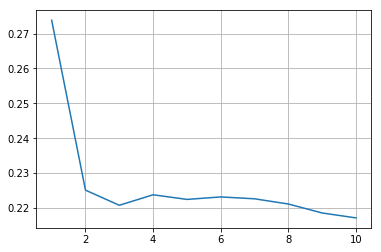

In [24]:
res = [np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i), X, target, cv=3)) for i in range(1,11)]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(range(1, 11),res)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

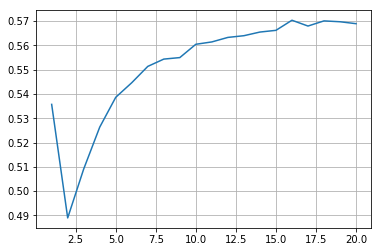

In [25]:
res = [np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i, metric = 'cosine'), X, target, cv=3)) for i in range(1,21)]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(range(1, 21),res)

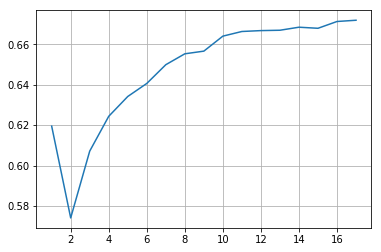

In [26]:
vectorizer = TfidfVectorizer(max_features = 20000,stop_words=ENGLISH_STOP_WORDS)
X_tfidf = vectorizer.fit_transform(data)
y = target
res = [np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i, metric = 'cosine'), X_tfidf, y, cv=3)) for i in range(1,18)]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(range(1, 18),res)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [27]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
test_data = newsgroups_test['data']
test_target = newsgroups_test['target']
data = newsgroups['data']
target = newsgroups['target']
vectorizer = TfidfVectorizer(max_features = 40000,stop_words=ENGLISH_STOP_WORDS)


In [28]:
X_test = vectorizer.fit_transform(test_data)
X_train = vectorizer.transform(data)

In [29]:

clf = MyKNeighborsClassifier(n_neighbors=16, metric='cosine')
clf.fit(X_train, target)
np.set_printoptions(threshold=100)
accuracy_score(clf.predict(X_test), test_target)

0.6152416356877324

In [30]:
vectorizer = CountVectorizer(max_features = 20000,stop_words=ENGLISH_STOP_WORDS)

X_test = vectorizer.fit_transform(test_data)
X_train = vectorizer.transform(data)

clf = MyKNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, target)
np.set_printoptions(threshold=100)
accuracy_score(clf.predict(X_test), test_target)

0.2015400955921402

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.